# One Dimensional hard spheres

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from numpy.random import random, seed
import seaborn as sns
from time import time
seed(1234)

## 1. Direct Sampling

In [3]:
def directSampling(L, sigma) :
    """Sampling of 2 1D-balls of size 2*sigma, on a 1D-line of length L."""
    n = 2
    pos = np.zeros(n)
    acc = False
    while acc == False : # while overlap, try again
        # Choose the position of a ball between [sigma, L-sigma]
        pos[0] = sigma + random()*(L-2*sigma)
        pos[1] = sigma + random()*(L-2*sigma)
        if abs(pos[1] - pos[0]) >= 2*sigma : # if no overlap, keep and stop
            acc = True
    return pos

In [4]:
L, sigma=8, 0.75
H = np.array([directSampling(L, sigma) for i in range(10)])

In [5]:
def plot1(H) :
    fig, ax = plt.subplots(2,sharex=True,figsize=(6,8))
    ax[0].hist(H[:, 0], bins = 100, normed = 1, color = 'red', alpha = 0.6)
    ax[0].set_title('Position of ball 1')
    ax[0].set_ylim([0,0.25])
    ax[1].hist(H[:, 1], bins = 100, normed = 1, color = 'orange', alpha = 0.6)
    ax[1].set_title('Position of ball 2')
    ax[1].set_ylim([0,0.25])
    plt.show()

In [6]:
L, sigma = 8, 0.75
H = np.array([directSampling(L, sigma) for i in range(10**6)])

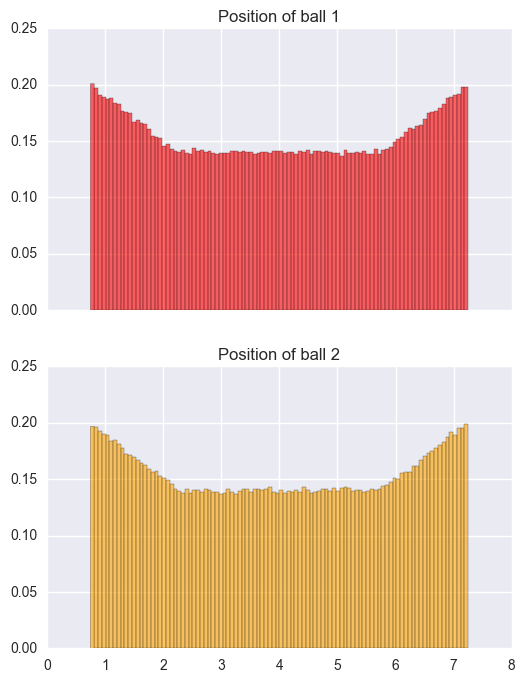

In [7]:
plot1(H)

This histogram shows the distribution of the two balls, and more especially the depletion effect on the border sides, while on the center of the histograms, we can see a plateau. An important remark is that we have the same distribution for the two balls, which is expected since they play the same role.

## 2. A Wrong Sampling

In [7]:
def wrongSampling(L, sigma) :
    """Wrong sampling of 2 1D-balls of size 2*sigma, on a 1D-line of length L."""
    n = 2
    pos = np.zeros(n)
    pos[0] = sigma + random()*(L-2*sigma)
    acc = False
    while acc == False : # while overlap, try again
        # Choose the position of a ball between [sigma, L-sigma]
        pos[1] = sigma + random()*(L-2*sigma)
        if abs(pos[1] - pos[0]) >= 2*sigma : # if no overlap, keep and stop
            acc = True
    return pos

In [8]:
def plot2(H, W) :
    fig, ax = plt.subplots(2,sharex=True,figsize=(6,8))
    ax[0].hist(H[:, 1], bins = 100, normed = 1, color = 'red', alpha = 0.6)
    ax[0].set_title('Position of ball 2')
    ax[0].set_ylim([0,0.25])
    ax[1].hist(W[:, 1], bins = 100, normed = 1, color = 'orange', alpha = 0.6)
    ax[1].set_title('Wrong position of ball 2')
    ax[1].set_ylim([0,0.25])
    plt.show()

In [9]:
L, sigma = 8, 0.75
W = np.array([wrongSampling(L, sigma) for i in range(10**6)])

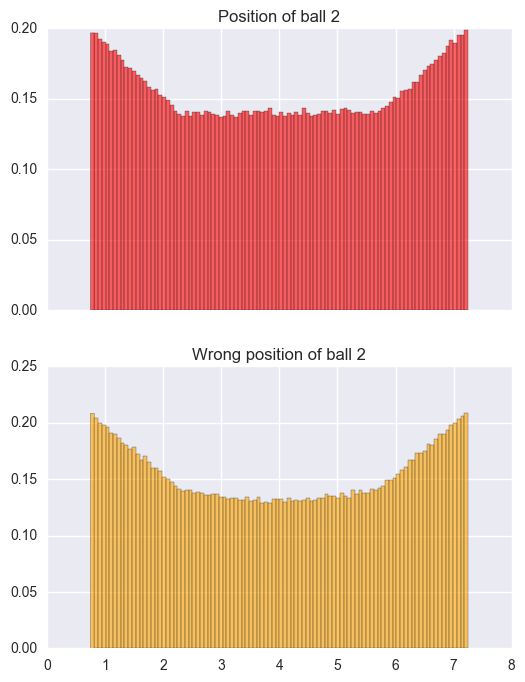

In [10]:
plot2(H, W)

We observe that for this sampling, the histogram of positions is not the same for the two balls, which already suggests that the procedure is wrong since the two balls should have the same probability distribution for symmetry reasons. In particular, for the second ball we have a 'pit' around the center of the zone, which corresponds to the effect of the first ball

## 3. A Naive Sampling

In [133]:
def naiveSampling(n, L, sigma) :
    reject = 0
    acc = False
    while acc != True :
        pos = random(size = n)*(L-2*sigma) + sigma
        x, y = np.ones((n, n))*pos, np.transpose(np.ones((n, n))*pos)
        z =  np.abs(x - y) >= 2*sigma
        np.fill_diagonal(z, True)
        if np.sum(z) == n*n :
            acc = True
        else :
            reject += 1
    return pos, reject

Here, we implemented a modified version of the given naive algorithm. Instead of comparing every step, and stop if two spheres overlap, which is very long with for loops in Python, we generate an array of positions of the spheres :
$$p = [x_{1}, ..., x_{n}]$$
then a matrix $M$ such that $M_{ij} = |x_i - x_j|$ (corresponds to the Gram matrix of distances).

$$\begin{array}{cccc}
|x_{1} - x_{1}| & |x_{1} - x_{2}| & ... & |x_{1} - x_{n}| \\
|x_{2} - x_{1}| & |x_{2} - x_{2}| & ... & |x_{2} - x_{n}| \\
\vdot & & \ddot & \vdot \\
|x_{n} - x_{1}| & |x_{n} - x_{2}| & ... & |x_{n} - x_{n}|
\end{array}$$

This matrix gives us the absolute distance between the position $x_{i}$ and $x_{j}$ for each $(i, j)$. Thus, the matrix is a symmetric matrix with zero-coefficients in the diagonal.
We then compare each of the coefficients to $2\sigma$ and return a boolean matrix (True if the coefficient is greater than $2\sigma$, i.e. : no overlap ; False else).
Finally, adding True values for the diagonal, we accept the initial distribution if and only if all the coefficients are True values, here if the sum of all booleans give $n^{2}$, the size of the matrix.
If two balls overlap, then the total sum is smaller than $n^{2}$ ad we reject the initial distribution.

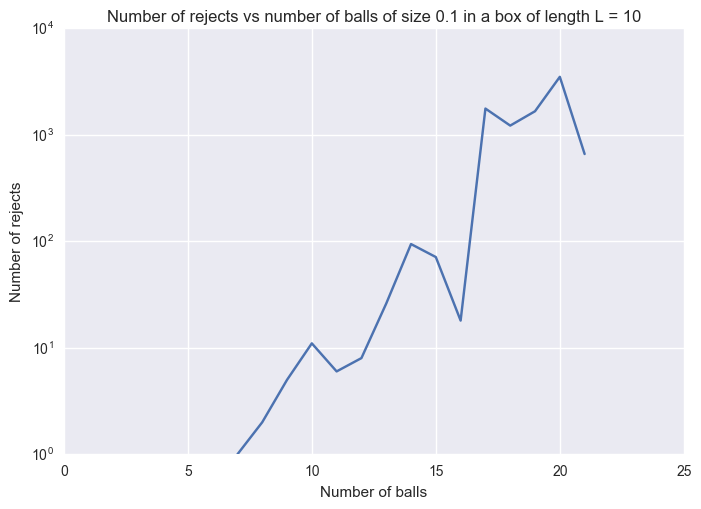

In [12]:
seed(1)
L, sigma = 10, 0.1
N = 22
dat = np.zeros(N-2)
for i in range(2, N):
    a, dat[i-2] = naiveSampling(i, L, sigma)

plt.semilogy(range(2, N), dat)
plt.xlabel('Number of balls')
plt.ylabel('Number of rejects')
plt.title('Number of rejects vs number of balls of size ' + str(sigma) + 
          ' in a box of length L = ' + str(L))
plt.show()

In the last graph, we see that the number of rejects increases exponentially, which is the main problem of the naive sampling, making it very slow for large densities. We can sometimes observe a decrease of the number of rejects, which are "lucky" configurations that converged fastly.

## 4. A Clever Sampling

In [111]:
def cleverSampling(n, L, sigma):
    if (L-2*n*sigma < 0):
        print('Error: the given parameters do not allow any configuration')
        return None
    pos = random(size = n)*(L-2*n*sigma)
    pos = np.sort(pos)
    pos = pos + (2*np.array(range(0,n)) + 1)*sigma
    return pos

In [137]:
n, L, sigma = 9, 20, 0.75
t1 = time()
X1 = naiveSampling(n,L,sigma)
t2 = time()
X2 = cleverSampling(n,L,sigma)
t3 = time()
print('Time for naive sampling = ' + str(t2-t1))
print('Time for clever sampling = ' + str(t3-t2))

Time for naive sampling = 0.08121657371520996
Time for clever sampling = 0.0


We notice that for high densities, naive sampling needs some consequent time to generate a configuration, while clever sampling still generates configurations instantly: it is almost unaffected by value of density!

## 5. Histograms of positions via clever sampling

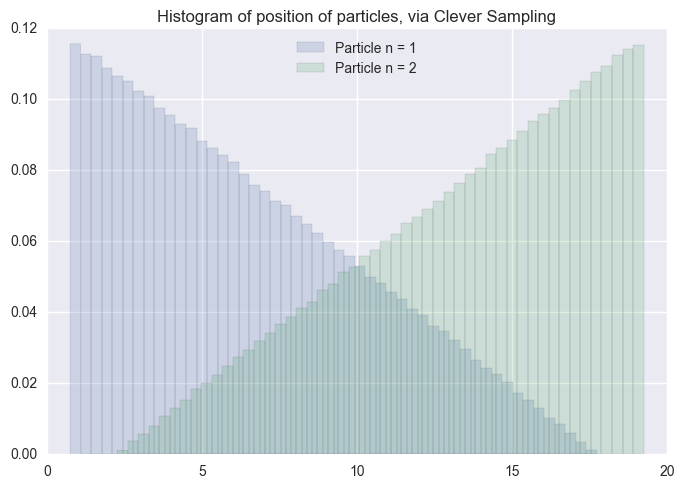

In [138]:
N, n, L, sigma = 10**6, 2, 20, 0.75
dat= np.zeros((N, n))
for k in range(N):
    dat[k] = cleverSampling(n, L, sigma)

for l in range(n):
    plt.hist(dat[:,l], bins = 50, normed = True, alpha = 0.2, label = 'Particle n = ' + str(l+1))

plt.title('Histogram of position of particles, via Clever Sampling')
    
plt.legend(loc='best') ; plt.show()

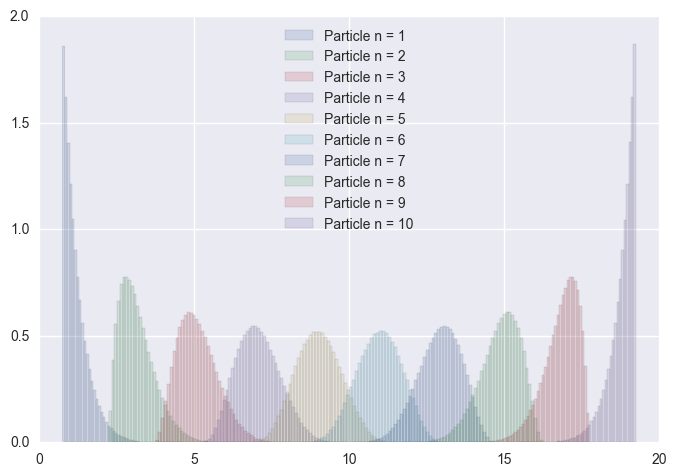

In [139]:
N, n, L, sigma = 10**6, 10, 20, 0.75
dat= np.zeros((N, n))
for k in range(N):
    dat[k] = cleverSampling(n, L, sigma)

a = [0 for i in range(n)]

for l in range(n):
    a[l], bins, normed = plt.hist(dat[:,l], 50, normed = True, alpha = 0.2, label = 'Particle n = ' + str(l+1))

plt.legend(loc='best') ; plt.show()

In the two graphs above, we actually obtain the same result than before, but it is hidden. Indeed, just before the mapping step, we sort the list of the positions to get an ordered list. But in the first case, where we accept or reject a distribution of positions, the two particles were indistinguishable, which is not the case here.

Let us consider two balls, labeled 1 and 2, at respective positions $x_{1}$ and $x_{2}$, with $x_{1} < x_{2}$ (no overlap). Now, we take a third ball, labeled 3. There are three cases :
- If $x_{3} > x_{2} > x_{1}$, then the three balls keep they labelling.
- Else if $x_{2} > x_{3} > x_{1}$, then ball 1 stays ball 1 : $1 \rightarrow 1$, but $2 \rightarrow 3$, and $3 \rightarrow 2$, so that we now have $x_{1} < x_{2} < x_{3}$.
- Else, $x_{2} > x_{1} > x_{3}$, we also exchange the labels : $1 \rightarrow 2$, $2 \rightarrow 3$ and $3 \rightarrow 1$

This means that whatever could be the initial distribution, the sorting imposes some kind of "confining" to the marginal distribution of a ball. Indeed, each ball has a defined label depending on its position : ball $i$ will always be between $i-1$ and $i+1$. But because of this sorting procedure, the minimal and maximal positions that ball $i$ can reach are predefined : the minimum position of ball $i$ is when all the balls between $[1, i-1]$ are sticked to the left (with no overlap) so it is $$x_{\min}^{(i)} = \sigma + ( 2\sigma + ... + 2\sigma) + \sigma = 2\sigma + (i-1)(2\sigma) = 2i\sigma$$
and the maximal position of ball $i$ is
$$x_{\max}^{(i)} = (L - \sigma) - (2\sigma + ... + 2\sigma) - \sigma = L - 2\sigma - (n-i)(2\sigma) = L - 2(n+1-i)\sigma $$

## 6. Computing the distribution

Given the partition function $Z=Z_{n,L}$, the probability of having a given configuration $(x_1,x_2..,x_n)$ is the following

$$\begin{equation*}
P(x_1,x_2..,x_n)= \frac{\textbf{1}_c (x_1,x_2..,x_n)}{Z}
\end{equation*}$$

where $\textbf{1}_c$ is the indicator function of configurations, equal to $1$ for possible configurations and $0$ otherwise.

We want to compute the probability that there is a particle at $x$. This amounts to computing the number of configurations where there is a particle at $x$. Let's consider the following integral

\begin{equation*}
 \int_0^L dx_1dx_2...dx_n \textbf{1}_c (x_1,x_2..,x_n) \left( \delta(x-x_1) + \delta(x-x_2) ... + \delta(x-x_n) \right)
\end{equation*}

We claim that the previous integral is proportional to the probability density that there is a particle at $x$. This is true because for a given configuration $(x_1...x_n)$ we have two possibilities:
- The configuration is impossible (overlap or particle at edge) in which case the indicator function is equal to $0$ and the configuration is not counted.
- The configuration is possible, the indicator function is equal to $1$. We have here two cases: either $x=x_k$ for some index $k$ in which case the configuration is counted, or $x$ is different from all the $x_k$, in which case none of the Dirac masses is "equal to $1$" and the configuration is not counted. Note that since the configuration is possible, these are the two only cases (we can't have two or more particles at $x$).

Integrating each Dirac mass over the corresponding variable, and using the fact that all the $x_k$ play a symmetric role in the indicator function, we get to the following function

\begin{equation*}
f(x)= n \int_0^L dx_2...dx_n \textbf{1}_c (x,x_2..,x_n)
\end{equation*}

The $n$ factor can be omitted. This is the density of having a particle at $x$ (up to a renormalization).We have then to compute an integral of dimension $n-1$, which can be done easily via MC sampling. The procedure is the following: for each point $x$, generate a configuration of $n-1$ particles $(x_2,x_3..x_n)$, then count $1$ if $(x,x_2,x_3..x_n)$ is a valid configuration of $n$ particles and $0$ otherwise. 

/!\ WARNING TO READER: since we are generating distributions without clever sampling, the procedure is highly time consuming. Please consider this before running again the following cells. You can find the plot for $L=20$, $\sigma=.75$ and $n=10$ in the PDF file. To compute quick plots, reduce the number of particles $n$ and the value of $iters$

In [128]:
n = 10  # number of particles
L = 20
sigma = 0.75

In [129]:
# Computing data via clever sampling, for histograms
N= 10**6
dat= np.zeros((N, n))
for k in range(N):
    dat[k] = cleverSampling(n, L, sigma)
data = np.ravel(dat)

In [54]:
def test_config3(x,X,sigma,L):
    
    # This function takes x which is the array of positions between 0 and L, X which contains n-1 sampled points for each
    # position in x, sigma and L.
    # Putting X and x together, we will have constructed a configuration of n points for each element of x.
    # The function outputs an array of booleans, which indicate for each configuration whether it is valid or not.

    X_t = np.concatenate((X,np.expand_dims(x,axis=1)),axis=1)
        
    A = np.repeat(np.expand_dims(X_t,axis=1),len(X_t[0]),axis=1)
    A = np.abs(A-np.transpose(A,axes=(0,2,1))) + 2*sigma*np.repeat(np.array([np.diag(np.ones(len(X_t[0])))]),len(X_t),axis=0)
        
    B = A < 2*sigma
    
    test1 = np.sum(B,axis=(1,2))

    test2 = np.sum(X_t < sigma,axis=1)
    
    test3 = np.sum(X_t > L - sigma,axis=1)

    return (test1 + test2 + test3 == 0)

In [106]:
x = np.linspace(0,20,100)
s = np.zeros(100)
t1 = time()
iters = 10000000*20 # number of simulations for each point of x


for i in range(iters):
    X = sigma + np.random.rand(100,n-1)*(L-2*sigma) # samples n-1 points for each point of x
    s = s + test_config3(x,X,sigma,L) # tests the corresponding configurations, and count 1 if it is valid
    if i%(iters//10) == 0:
        print(i)

        
print(time()-t1)

0
20000000
40000000
60000000
80000000
100000000
120000000
140000000
160000000
180000000
27454.89812707901


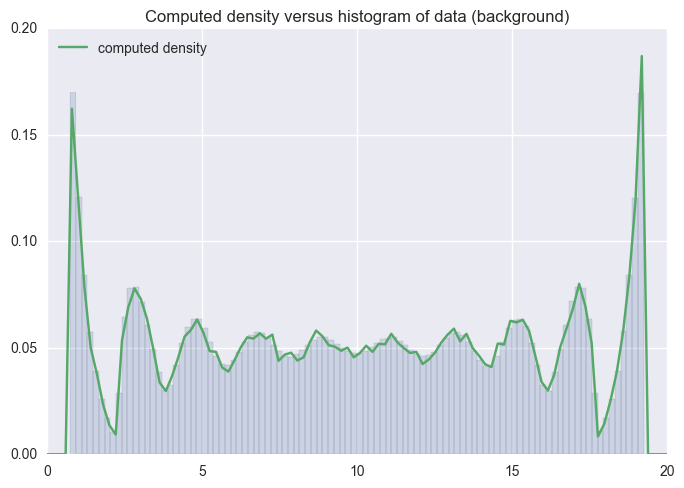

In [131]:
s1 = s/sum(s)
plt.hist(data, 100, normed = True, alpha = 0.2)
plt.plot(x,s1/(x[1]-x[0]),label='computed density')
plt.legend(loc="best")
plt.title("Computed density versus histogram of data (background)")
plt.show()

We find that indeed, the computed density matches perfectly the histogram of positions obtained via the previous simulations via cleversampling. Notice that the computed density is not perfectly smooth, which is due to the extremely high number of tries needed to sample valid configurations via direct sampling ($200000000$ configurations for each $x$ were used for the previous plot!)